# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- homework_modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)
- homework_differentiation.ipynb

In [ ]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [ ]:
# (re-)load layers
RUN_TESTS = False
%run homework_modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

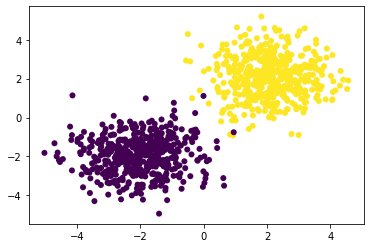

In [ ]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors = 'none')

Define a **logistic regression** for debugging. 

In [ ]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [ ]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [ ]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

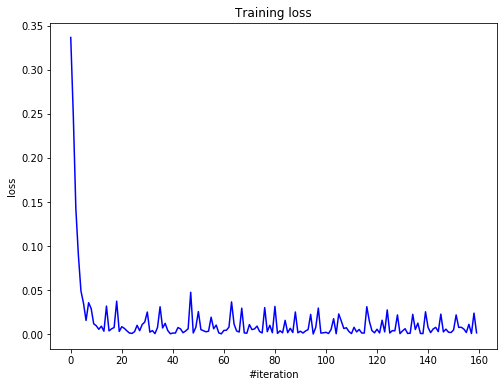

Current loss: 0.001528


In [ ]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers import Dropout

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

Text(0, 0.5, 'Number of images')

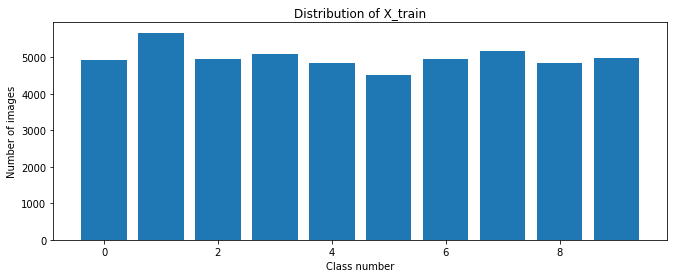

In [ ]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

num_of_classes, num_of_samples = np.unique(y_train, return_counts=True)
plt.figure(figsize=(11, 4))
plt.bar(num_of_classes, num_of_samples)
plt.title("Distribution of X_train")
plt.xlabel("Class number")
plt.ylabel("Number of images")

One-hot encode the labels first.

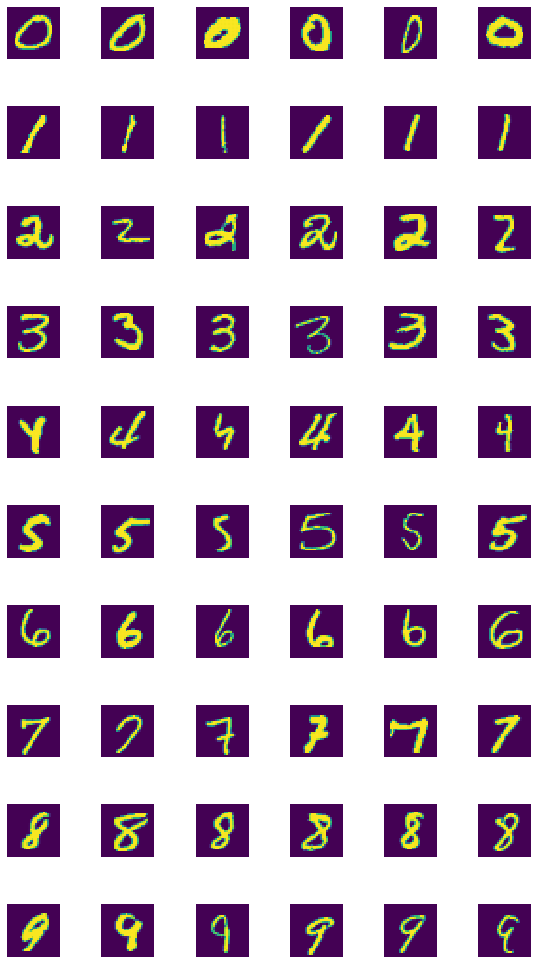

In [ ]:
import random

cols = 6
num_classes = 10

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(8, 14))
fig.tight_layout()

for i in range(cols):
    for j in range(num_classes):
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :])
        axs[j][i].axis("off")

In [ ]:
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)
y_val_cat = to_categorical(y_val, num_classes)

In [ ]:
num_pixels = 784
img_raw_size = (28, 28)
X_train_norm = X_train.reshape(-1, num_pixels)
X_test_norm = X_test.reshape(-1, num_pixels)
X_val_norm = X_val.reshape(-1, num_pixels)
print(X_train_norm.shape, X_test_norm.shape, X_val_norm.shape)

(50000, 784) (10000, 784) (10000, 784)


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [ ]:
import tensorflow as tf

batch_size = 400
epochs = 30
learning_rate = 0.01

def create_model(act1='tanh', act2='relu', act3='softmax', optimizer=None, batch_norm=True):
    if optimizer == 'sgd':
        optimizer = SGD(lr=learning_rate, decay=1e-6, momentum=0.9)
    else:
        optimizer = Adam(lr=learning_rate)
    model = Sequential()
    model.add(Dense(64, input_dim=num_pixels))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Activation(act1))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation=act2))
    model.add(Dense(num_classes, activation=act3))
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def custom_model(act='relu', optimizer='adam'):
    return create_model(act, act, optimizer=optimizer)

def fit_funct(model, verbose_level=0):
    history = model.fit(X_train_norm,
                        y_train_cat,
                        validation_data=(X_val_norm, y_val_cat),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=verbose_level,
                        shuffle=1)
    return history

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [ ]:
import tensorflow as tf

diff_activation = {
    'ReLU': custom_model('relu'),
    'ELU': custom_model('elu'),
    'LeakyReLU': custom_model(tf.nn.leaky_relu),
    'SoftPlus': custom_model('softplus')
}

for key, model in diff_activation.items():
    history = fit_funct(model)
    diff_activation[key] = history

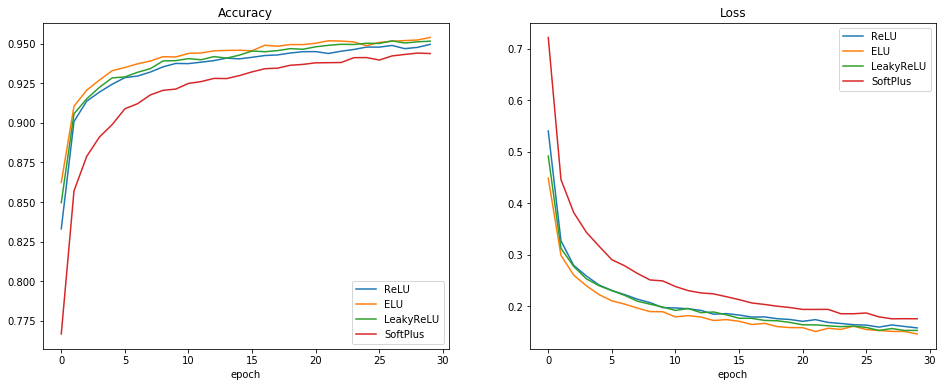

In [ ]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(121)
for key, history in diff_activation.items():
    ax.plot(history.history['accuracy'], label=key)
    ax.set(title = 'Accuracy', xlabel='epoch')
ax.legend()

ax = fig.add_subplot(122)
for key, history in diff_activation.items():
    ax.plot(history.history['loss'], label=key)
    ax.set(title = 'Loss', xlabel='epoch')
ax.legend()

plt.show()

In [ ]:
model = create_model(batch_norm = False)
history = fit_funct(model)
model_norm = create_model(batch_norm = True)
history_norm = fit_funct(model_norm)

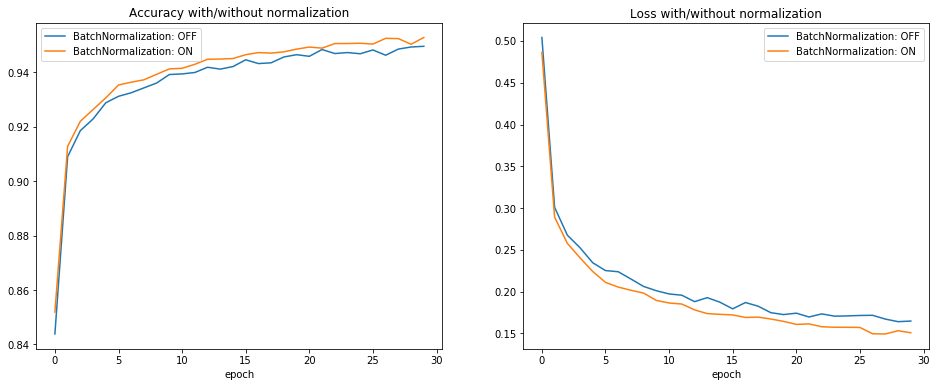

In [ ]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(121)
ax.plot(history.history['accuracy'], label='BatchNormalization: OFF')
ax.plot(history_norm.history['accuracy'], label='BatchNormalization: ON')
ax.set(title = 'Accuracy with/without normalization', xlabel='epoch')
ax.legend()

ax = fig.add_subplot(122)
ax.plot(history.history['loss'], label='BatchNormalization: OFF')
ax.plot(history_norm.history['loss'], label='BatchNormalization: ON')
ax.set(title = 'Loss with/without normalization', xlabel='epoch')
ax.legend()

plt.show()

In [ ]:
model_adam = custom_model(optimizer='adam')
%time h = fit_funct(model_adam)

model_sgd = custom_model(optimizer='sgd')
%time h = fit_funct(model_sgd)

Wall time: 35.4 s
Wall time: 33.7 s


**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [ ]:
model = create_model()
model.summary()

Model: "sequential_117"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_346 (Dense)            (None, 64)                50240     
_________________________________________________________________
batch_normalization_115 (Bat (None, 64)                256       
_________________________________________________________________
activation_117 (Activation)  (None, 64)                0         
_________________________________________________________________
dropout_117 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_347 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_348 (Dense)            (None, 10)                330       
Total params: 52,906
Trainable params: 52,778
Non-trainable params: 128
______________________________________________

In [ ]:
history = fit_funct(model, 2)

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
 - 2s - loss: 0.4643 - accuracy: 0.8561 - val_loss: 0.2213 - val_accuracy: 0.9331
Epoch 2/30
 - 1s - loss: 0.2890 - accuracy: 0.9129 - val_loss: 0.1897 - val_accuracy: 0.9426
Epoch 3/30
 - 1s - loss: 0.2620 - accuracy: 0.9208 - val_loss: 0.1519 - val_accuracy: 0.9550
Epoch 4/30
 - 1s - loss: 0.2340 - accuracy: 0.9291 - val_loss: 0.1411 - val_accuracy: 0.9598
Epoch 5/30
 - 1s - loss: 0.2258 - accuracy: 0.9316 - val_loss: 0.1358 - val_accuracy: 0.9598
Epoch 6/30
 - 1s - loss: 0.2154 - accuracy: 0.9336 - val_loss: 0.1462 - val_accuracy: 0.9553
Epoch 7/30
 - 1s - loss: 0.2055 - accuracy: 0.9363 - val_loss: 0.1316 - val_accuracy: 0.9593
Epoch 8/30
 - 1s - loss: 0.1997 - accuracy: 0.9384 - val_loss: 0.1317 - val_accuracy: 0.9617
Epoch 9/30
 - 1s - loss: 0.2008 - accuracy: 0.9387 - val_loss: 0.1179 - val_accuracy: 0.9643
Epoch 10/30
 - 1s - loss: 0.1891 - accuracy: 0.9419 - val_loss: 0.1188 - val_accuracy: 0.9638
Epoch 11/30
 - 1s -

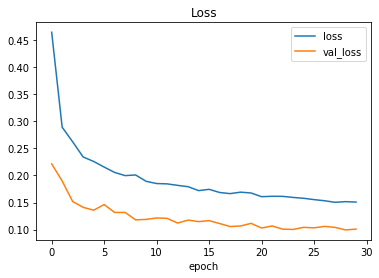

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

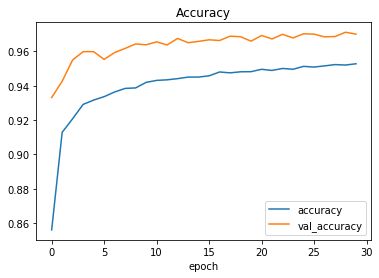

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

Print here your accuracy on test set. It should be around 90%.

In [ ]:
score, accuracy = model.evaluate(X_test_norm, y_test_cat, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 0.10770029878458008
Test accuracy: 0.9678999781608582


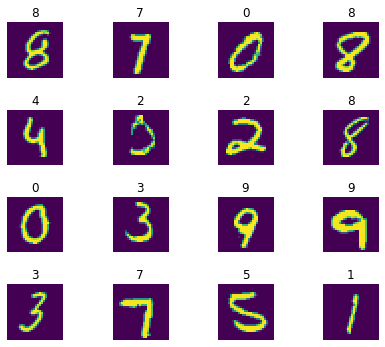

In [ ]:
width = 4

fig, axs = plt.subplots(nrows=width, ncols=width, figsize=(width + 2, width + 1))
fig.tight_layout()

for i in range(width):
    for j in range(width):
        x_selected = X_train[y_train == j]
        selected = X_val_norm[random.randint(0, len(X_val_norm - 1))]
        predicted = np.argmax(model.predict(selected[None]))
        axs[j][i].imshow(selected.reshape(*img_raw_size))
        axs[j][i].axis("off")
        axs[j][i].set_title(predicted)